In [48]:
import numpy as np
import HW5_utils_data as utils
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.random.seed(0)

# Response simulation

In [49]:
# Parameters: Model
a = 0.5
b = 0.025
c = 0.25
d = 0.005
x0= [60, 50]

# Temporal parameters:
dt = 0.1
T = 100
sysparam = [a, b, c, d]
tparam = [dt, 0, T]
xt, t = utils.lotka_volterra(x0, tparam, sysparam) 

noise_std = 0.02
xt = xt + noise_std * np.std(xt, axis=1, keepdims=True) * np.random.randn(*xt.shape)
sigma=np.std(xt, axis=1, keepdims=True)

# Discretization Step

In [50]:
def cds(X, dt):
    n = X.shape[1]
    X_dot = np.zeros_like(X)

    if n >= 5:
        # Interior points
        X_dot[:,2:-2] = (-X[:,:-4] + 8*X[:,1:-3] - 8*X[:,3:-1] + X[:,4:])/(12*dt)

        # Boundary points
        coeffs = np.array([[-1, 8, -13, 8, -1], [-1, 8, -9, 2, 0], [0, 2, -9, 8, -1], [1, -8, 13, -8, 1]])
        for i, c in enumerate(coeffs):
            X_dot[:, i] = np.dot(X[:, :5], c) / (6*dt)

    else:
        X_dot[:,1:-1] = (X[:,2:] - X[:,:-2])/(2*dt)
        X_dot[:,0] = (-X[:,1] + X[:,0])/dt
        X_dot[:,-1] = (X[:,-1] - X[:,-2])/dt

    return X_dot


# Generating testing data

In [51]:
xt_dot = cds(xt, dt)

In [52]:
# Function to evaluate the Lotka-Volterra model
def lotka_volterra(X, params):
    a, b, c, d = params
    X1, X2 = X
    dX1_dt = a * X1 - b * X1 * X2
    dX2_dt = -c * X2 + d * X1 * X2
    return np.array([dX1_dt, dX2_dt])

# Function to evaluate neg-log-likelihood
def neg_log_likelihood(params, X_dot_obs, X, sigma):
    X_dot = lotka_volterra(X, params)
    log_likelihood = -0.5 * np.sum((X_dot_obs - X_dot)**2 / sigma**2)
    return -log_likelihood

# Function to evaluate the log-prior
def log_prior(params):
    if np.any(params < 0):
        return -np.inf
    else:
        return -np.sum(np.log(params))

# Define the neg-log-posterior function
def neg_log_posterior(params, X_dot_obs, X, sigma):
    return neg_log_likelihood(params, X_dot_obs, X, sigma) - log_prior(params)


In [53]:
initial_params = [0.3, 0.03, 0.3, 0.01]

result = minimize(neg_log_posterior, initial_params, args=(xt_dot, xt, sigma))
result.x

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


array([0.21963045, 0.00270357, 0.1679833 , 0.00132176])

In [54]:
# Extract mean and covariance from result
mean_params = result.x
covariance_params = -result.hess_inv

# Extract parameters
a_pred, b_pred, c_pred, d_pred = mean_params
initial_conditions = [60, 50]

# Temporal parameters
dt = 0.1
T = 100
system_params = [a_pred, b_pred, c_pred, d_pred]
temporal_params = [dt, 0, T]

# Generate predictions using Lotka-Volterra model
predicted_values, time_values = utils.lotka_volterra(initial_conditions, temporal_params, system_params)

In [55]:
# Calculate 95% CI for predicted states
significance_level = 0.05  # Significance level for 95% CI
num_time_points = predicted_values.shape[1]  # Number of time points
degrees_of_freedom = num_time_points - 1  # Degrees of freedom

# Prey Estimate
prey_mean_value = np.mean(predicted_values[0, :])
prey_std_deviation = np.std(predicted_values[0, :], ddof=1)

# Predator Estimate
predator_mean_value = np.mean(predicted_values[1, :])
predator_std_deviation = np.std(predicted_values[1, :], ddof=1)

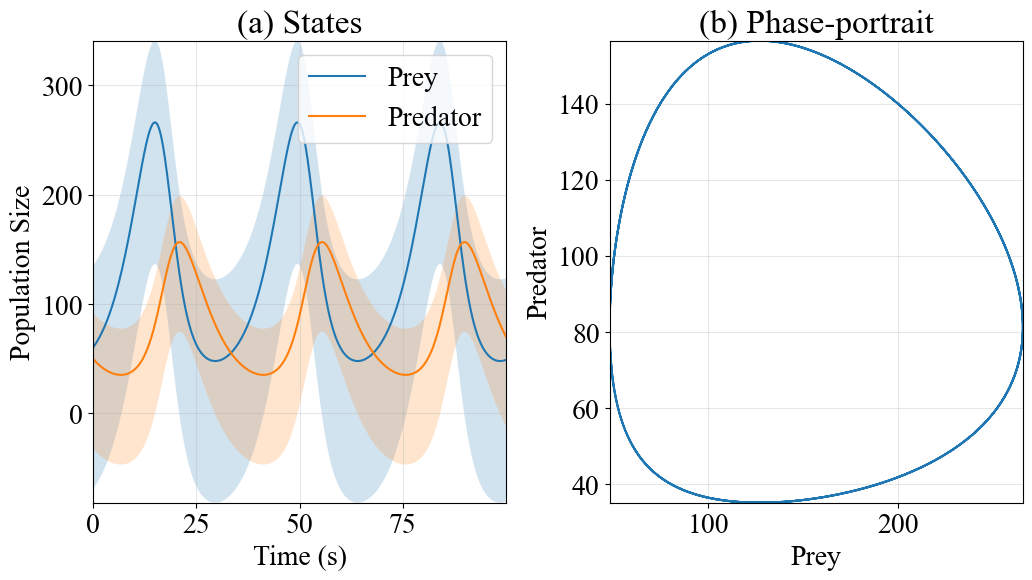

In [56]:
# Set font family and size
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 20

# Create subplots
fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=100)
plt.subplots_adjust(wspace=0.25, hspace=0.3)
ax = ax.flatten()

# Plot states
ax[0].plot(time_values, predicted_values[0, :])
ax[0].plot(time_values, predicted_values[1, :])
ax[0].fill_between(time_values, predicted_values[0, :] - prey_mean_value, predicted_values[0, :] + prey_std_deviation, alpha=0.2, label='95% CI Prey')
ax[0].fill_between(time_values, predicted_values[1, :] - predator_mean_value, predicted_values[1, :] + predator_std_deviation, alpha=0.2, label='95% CI Predator')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Population Size')
ax[0].legend(['Prey', 'Predator'], loc=1)
ax[0].set_title('(a) States')
ax[0].margins(0)
ax[0].grid(alpha=0.3)

# Plot phase portrait
ax[1].plot(predicted_values[0, :], predicted_values[1, :])
ax[1].set_xlabel('Prey')
ax[1].set_ylabel('Predator')
ax[1].set_title('(b) Phase-portrait')
ax[1].margins(0)
ax[1].grid(alpha=0.3)

# Show plot
plt.show()